#Sentiment classification mini-project:
- Load product reviews data
- Clean and normalize text
- Vectorize using BoW, TF-IDF, and bi-grams
- Train multiple classifiers per vectorization
- Select and report the best model (macro F1)
- Plot confusion matrix for the winner


##Installing Required Libraries

In [1]:
%pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 10.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
openc

##Importing Required Libraries

In [1]:
import argparse
import os
import re
import warnings
from dataclasses import dataclass
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

##Defining Neccessary Class and Functions

In [5]:
@dataclass
class ModelResult:
    label: str
    macro_f1: float
    estimator: object
    X_test: pd.DataFrame
    y_test: pd.Series
    y_pred: np.ndarray


def _ensure_nltk():
    try:
        _ = stopwords.words("english")
    except LookupError:
        nltk.download("stopwords")
    try:
        _ = wordnet.synsets("dog")
    except LookupError:
        nltk.download("wordnet")
        nltk.download("omw-1.4")

def strip_non_alnum(text: str) -> str:
    return re.sub(r"[^A-Za-z0-9]+", " ", text or " ").strip()

def remove_stop_words(text: str, stopset: set) -> str:
    tokens = (text or "").split()
    return " ".join([t for t in tokens if t.lower() not in stopset])

def stem_with_porter(text: str, stemmer: PorterStemmer) -> str:
    tokens = (text or "").split()
    return " ".join([stemmer.stem(t) for t in tokens])

def _wordnet_pos_from_tag(tag: str) -> str:
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("R"):
            return wordnet.ADV
    return wordnet.NOUN

def lemmatize_simple(text: str, lemmatizer: WordNetLemmatizer) -> str:
    tokens = (text or "").split()
    return " ".join([lemmatizer.lemmatize(t) for t in tokens])

def basic_clean_pipeline(series: pd.Series) -> pd.Series:
    _ensure_nltk()
    eng_stops = set(stopwords.words("english"))
    stemmer = PorterStemmer()
    lemm = WordNetLemmatizer()
    s = series.astype(str).str.lower().map(strip_non_alnum)
    s = s.map(lambda t: remove_stop_words(t, eng_stops))
    s = s.map(lambda t: stem_with_porter(t, stemmer))
    s = s.map(lambda t: lemmatize_simple(t, lemm))
    return s



def make_features_bow(corpus: pd.Series, max_features: int = 1000) -> pd.DataFrame:
    vec = CountVectorizer(max_features=max_features)
    feats = vec.fit_transform(corpus)
    return pd.DataFrame(feats.toarray(), columns=vec.get_feature_names_out())

def make_features_tfidf(corpus: pd.Series, max_features: int = 1000) -> pd.DataFrame:
    vec = TfidfVectorizer(max_features=max_features)
    feats = vec.fit_transform(corpus)
    return pd.DataFrame(feats.toarray(), columns=vec.get_feature_names_out())

def make_features_ngrams(corpus: pd.Series, max_features: int = 1000, ngram_range=(1, 2)) -> pd.DataFrame:
    vec = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
    feats = vec.fit_transform(corpus)
    return pd.DataFrame(feats.toarray(), columns=vec.get_feature_names_out())

def evaluate_on_splits(X: pd.DataFrame, y: pd.Series, name: str, random_state: int = 100) -> List[ModelResult]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    models = [
        ("RandomForest", RandomForestClassifier(random_state=random_state)),
        ("NaiveBayes", MultinomialNB()),
        ("GradientBoost", GradientBoostingClassifier(random_state=random_state)),
        ("AdaBoost", AdaBoostClassifier()),
    ]
    out: List[ModelResult] = []
    for label, clf in models:
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        score = f1_score(y_test, preds, average="macro")
        out.append(ModelResult(f"{label} - {name}", score, clf, X_test, y_test, preds))
    return out

def display_confusion(result: ModelResult):
    cm = confusion_matrix(result.y_test, result.y_pred, labels=np.unique(result.y_test))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(result.y_test),
                yticklabels=np.unique(result.y_test))
    plt.title(f"Confusion Matrix: {result.label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def miniProject1():
    warnings.filterwarnings("ignore")
    parser = argparse.ArgumentParser(description="Sentiment classification pipeline")
    parser.add_argument(
        "--csv",
        type=str,
        default=os.environ.get(
            "REVIEWS_CSV",
            "Product_Reviews.csv",
        ),
        help="Path to Product_Reviews.csv",
    )
    args, unknown = parser.parse_known_args()
    if not os.path.exists(args.csv):
        raise FileNotFoundError(
            f"Could not find data file at: {args.csv}. "
            f"Provide --csv path to Product_Reviews.csv"
        )
    df = pd.read_csv(args.csv)
    if "Product Review" not in df.columns or "Sentiment" not in df.columns:
        raise ValueError("Input CSV must include 'Product Review' and 'Sentiment' columns")
    df["clean_text"] = basic_clean_pipeline(df["Product Review"])
    bow = make_features_bow(df["clean_text"], max_features=1000)
    tfidf = make_features_tfidf(df["clean_text"], max_features=1000)
    ngram = make_features_ngrams(df["clean_text"], max_features=1000, ngram_range=(1, 2))
    y = df["Sentiment"]
    all_results: List[ModelResult] = []
    for label, X in [("BoW", bow), ("TF-IDF", tfidf), ("N-gram", ngram)]:
        all_results.extend(evaluate_on_splits(X, y, label, random_state=100))
    all_results.sort(key=lambda r: r.macro_f1, reverse=True)
    print("\nModel Performance (Macro F1):\n")
    for r in all_results:
        print(f"{r.label:28s} : {r.macro_f1:.4f}")
    best = all_results[0]
    print(f"\nBest Model: {best.label} (Macro F1 = {best.macro_f1:.4f})\n")
    print("Classification Report:\n")
    print(classification_report(best.y_test, best.y_pred))
    display_confusion(best)


## Installing NLTK Data

In [10]:
_ensure_nltk()

##Evaluating Model Performance (Macro F1) and Plotting Confusion Matrix


Model Performance (Macro F1):

NaiveBayes - BoW             : 0.5678
GradientBoost - N-gram       : 0.5271
NaiveBayes - N-gram          : 0.5042
RandomForest - TF-IDF        : 0.4979
RandomForest - N-gram        : 0.4979
RandomForest - BoW           : 0.4647
GradientBoost - BoW          : 0.4456
AdaBoost - TF-IDF            : 0.4233
GradientBoost - TF-IDF       : 0.4145
NaiveBayes - TF-IDF          : 0.3339
AdaBoost - BoW               : 0.2987
AdaBoost - N-gram            : 0.2987

Best Model: NaiveBayes - BoW (Macro F1 = 0.5678)

Classification Report:

              precision    recall  f1-score   support

    NEGATIVE       0.60      0.50      0.55        18
     NEUTRAL       0.26      0.26      0.26        19
    POSITIVE       0.89      0.90      0.89       165

    accuracy                           0.81       202
   macro avg       0.58      0.56      0.57       202
weighted avg       0.80      0.81      0.80       202



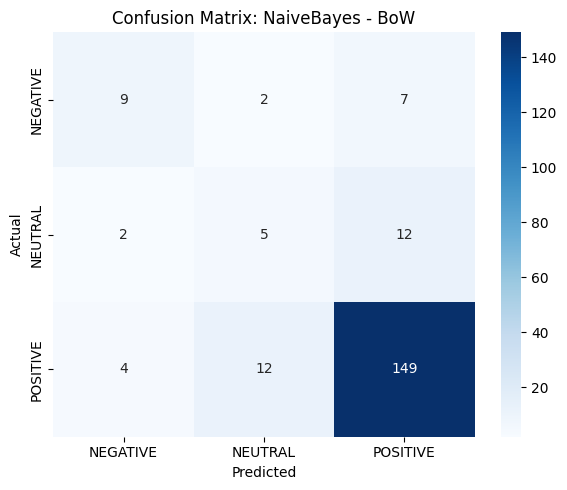

In [9]:
miniProject1()